# Sentiment

Visualize sentiment analysis. This notebook relies on sentiment scores per tweet stored in the directory `data/sentiment/pattern` . These sentiment scores can be generated with the script `scripts/sentiment-pattern-text.py` .

In [1]:
import datetime
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
DATASOURCE = "twitter"
DATADIRECTORYALL = f"../data/{DATASOURCE}/sentiment/"
DATADIRECTORYTEXT = f"../data/{DATASOURCE}/text/"
SENTIMENT = "sentiment"
COUNT = "count"
DATA = "data"
LABEL = "label"
HIGHLIGHT = "highlight"
HIGHLIGHTLABEL = "highlightlabel"
TEXT ="text"
IDSTR = "id_str"
DATE = "date"

In [4]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## Read hourly sentiment analysis by pattern's sentiment analysis

In [5]:
DEFAULTFILEPATTERN = "2.*z"

def getSentimentPerHour(dataDirectory,filePattern=DEFAULTFILEPATTERN):
    fileList = sorted(os.listdir(dataDirectory))
    sentimentPerHour = {}
    for inFileName in fileList:
        if re.search(filePattern,inFileName):
            if re.search(r"-00.out.gz",inFileName): squeal(inFileName)
            try: df = pd.read_csv(dataDirectory+inFileName,compression="gzip",header=None)
            except: continue
            sentiment = sum(df[1])/len(df)
            hour = inFileName[0:11]
            sentimentPerHour[hour] = { SENTIMENT:sentiment, COUNT:len(df) }
    sentimentPerHour = {key:sentimentPerHour[key] for key in sorted(sentimentPerHour.keys())}
    return(sentimentPerHour)

## Convert hourly analysis to day scores

In [6]:
def makeSentimentPerDay(sentimentPerHour):
    sentimentPerDay = {}
    for hour in sentimentPerHour:
        day = re.sub("..$","12",hour)
        if not day in sentimentPerDay: sentimentPerDay[day] = {SENTIMENT:0,COUNT:0}
        sentimentPerDay[day][SENTIMENT] += sentimentPerHour[hour][SENTIMENT]*sentimentPerHour[hour][COUNT]
        sentimentPerDay[day][COUNT] += sentimentPerHour[hour][COUNT]
    for day in sentimentPerDay:
        sentimentPerDay[day][SENTIMENT] /= sentimentPerDay[day][COUNT]
    return(sentimentPerDay)

## Visualize

In [7]:
DATEFORMATHOUR = "%Y%m%d-%H"
DATEFORMATMONTH = "%-d/%-m"
DATEFORMATHRSMINS = "%H:%M"
DEFAULTTITLE = "Polarity scores of Dutch tweets over time"
PLOTFILENAME = "sentiment-all.png"
ANNOTATE = "annotate"

def stringToDate(dateString):
    return(datetime.datetime.strptime(dateString,DATEFORMATHOUR))

def list_skip(list,skip_factor=0):
    return([list[i] for i in range(0,len(list)) if (i)%(skip_factor+1) == 0])

def visualizeSentiment(dataSources,title=DEFAULTTITLE,dateFormat=DATEFORMATMONTH,skip_factor=0):
    font = {"size":16}
    matplotlib.rc("font",**font)
    fig,ax = plt.subplots(figsize=(12,6))
    #plt.ylim(-0.14,0.16)
    ax.xaxis.set_major_formatter(mdates.DateFormatter(dateFormat))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        lineData = ax.plot_date(list_skip([stringToDate(key) for key in data if data[key][COUNT] > 1],skip_factor=skip_factor),
                                list_skip([data[key][SENTIMENT] for key in data if data[key][COUNT] > 1],skip_factor=skip_factor),
                                xdate=True,fmt="-",label=label)
        if HIGHLIGHT in dataSources[i]:
            highlight = dataSources[i][HIGHLIGHT]
            color = lineData[-1].get_color()
            if not HIGHLIGHTLABEL in dataSources[i]:
                ax.plot_date([stringToDate(key) for key in highlight],
                             [data[key][SENTIMENT] for key in highlight],\
                             fmt="o",color=color)
            else:
                highlightlabel = dataSources[i][HIGHLIGHTLABEL]
                ax.plot_date([stringToDate(key) for key in highlight],
                             [data[key][SENTIMENT] for key in highlight],\
                             fmt="o",color=color,label=highlightlabel)
        if ANNOTATE in dataSources[i]:
            for date1,date2,text in dataSources[i][ANNOTATE]:
                plt.annotate(text,(stringToDate(date2),data[date1][SENTIMENT]),color=color)
    plt.title(title)
    plt.legend(framealpha=0.2)
    plt.savefig(PLOTFILENAME)
    plt.show()
    return(ax)

## Process data obtained from all Dutch tweets

In [78]:
highlight = ["20200301-12","20200309-12","20200312-12","20200315-12","20200317-12","20200319-12","20200323-12","20200331-12",
             "20200407-12","20200415-12","20200421-12","20200429-12",
             "20200506-12","20200513-12","20200519-12","20200527-12",\
             "20200603-12","20200624-12",
             "20200722-12",
             "20200806-12","20200818-12",
             "20200901-12","20200918-12","20200928-12",
             "20201013-12",
             "20201103-12","20201117-12"]

In [9]:
annotate = [("20200220-12","20200221-12","(1)"),\
            ("20200302-12","20200303-12","(2)"),\
            ("20200312-12","20200313-12","(3)"),\
            ("20200322-12","20200323-12","(4)"),\
            ("20200330-12","20200331-12","(5)"),\
            ("20200413-12","20200414-12","(6)"),\
            ("20200421-12","20200422-12","(7)"),\
            ("20200428-12","20200429-12","(8)"),\
            ("20200430-12","20200501-12","(9)"),\
            ("20200511-12","20200512-12","(10)"),\
            ("20200526-12","20200527-12","(11)"),\
            ("20200601-12","20200603-12","(12)"),\
            ("20200608-12","20200609-12","(13)"),\
            ("20200622-12","20200623-12","(14)"),\
            ("20200708-12","20200709-12","(15)"),
            ("20200922-12","20200923-12","(16)"),
            ("20201006-12","20201007-12","(17)"),
            ("20201016-12","20201017-12","(18)"),
            ("20201029-12","20201030-12","(19)")]

In [77]:
sentimentPerHour = getSentimentPerHour(DATADIRECTORYALL)
sentimentPerDay = makeSentimentPerDay(sentimentPerHour)

20201130-00.out.gz


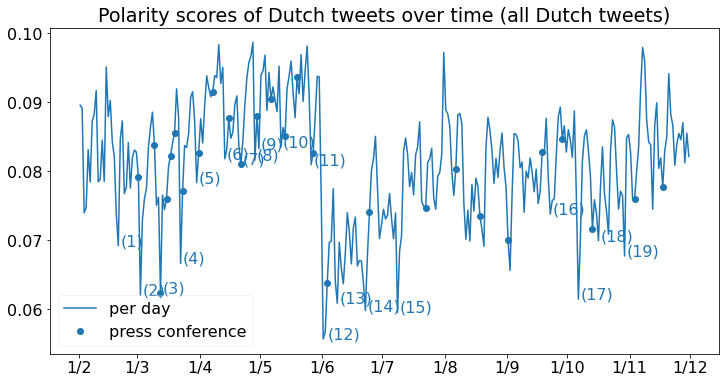

In [79]:
dummy = visualizeSentiment([{DATA:sentimentPerDay,LABEL:"per day",\
                             HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference",
                             ANNOTATE:annotate}],\
                           title=DEFAULTTITLE+" (all Dutch tweets)")

1. 20200220 terrorist attack Hanau, Germany
2. 20200302 newsitem: Netherlands financially supporting asylum seekers
3. 20200312 announcement of first national COVID-19 measures
4. 20200322 lack of social distancing in nature areas
5. 20200330 news item: EU donates millions to Morocco
6. 20200413 news item: anti-gay violence
7. 20200421 national press conference on COVID-19
8. 20200428 news item: lack of social distancing at IKEA
9. 20200430 news item: local coalition of CDA and FvD
10. 20200511 news item: etnic profiling by tax services
11. 20200526 news item: KLM boss receives bonus
12. 20200601 lack of social distancing at Amsterdam BLM demonstration
13. 20200608 attacks on left-wing politicians
14. 20200622 racism in tv programme Veronica Inside
15. 20200708 farmers protest
16. 20200922 Dutch VIPs involved in protest against measures (#ikdoenietmeermee)
17. 20201006 Eddie Van Halen dies 
18. 20201016 Paris teacher killed
19. 20201029 Nice terror attack

Find dates of sentiment minima with next code block and then look for relevant topics in tweets with these shell commands:
```
gunzip -c ../sentiment/pattern/20200820-* | cut -d, -f2 > ~/tmp/scores
gunzip -c 20200820-* | python3 ../../scripts/get-text.py | grep -v '^text$' | paste -d , ~/tmp/scores - |\
   sort | uniq -c | sort -nr | less
```

In [12]:
def sortDatesBySentiment(sentimentPerDay,month=""):
    return([(hourString,sentimentPerDay[hourString]) \
             for hourString in sorted(sentimentPerDay.keys(),key=lambda h:sentimentPerDay[h][SENTIMENT]) 
             if re.search(month,hourString)])

sortDatesBySentiment(sentimentPerDay,month="202008")

[('20200820-12', {'sentiment': 0.06915322844865378, 'count': 717266}),
 ('20200813-12', {'sentiment': 0.06989237983453746, 'count': 786275}),
 ('20200811-12', {'sentiment': 0.07015922240916372, 'count': 761896}),
 ('20200819-12', {'sentiment': 0.07160922109195542, 'count': 717558}),
 ('20200818-12', {'sentiment': 0.07354213634136757, 'count': 687296}),
 ('20200815-12', {'sentiment': 0.0742551933385362, 'count': 685389}),
 ('20200812-12', {'sentiment': 0.07438839933882142, 'count': 744895}),
 ('20200810-12', {'sentiment': 0.07537837323168245, 'count': 715004}),
 ('20200805-12', {'sentiment': 0.0765022295332868, 'count': 616144}),
 ('20200831-12', {'sentiment': 0.07770318337441649, 'count': 620875}),
 ('20200817-12', {'sentiment': 0.07776751480897987, 'count': 665255}),
 ('20200814-12', {'sentiment': 0.07809440784774856, 'count': 736476}),
 ('20200825-12', {'sentiment': 0.07824824765614334, 'count': 645933}),
 ('20200816-12', {'sentiment': 0.07902620418925808, 'count': 694022}),
 ('20200

## Get sentiment on topics

In [49]:
DATADIRECTORYSENTTOPIC = "../data/sentiment/topic/"

def getSentimentPerHourQuery(dataDirectory,query,filePattern=DEFAULTFILEPATTERN,computeMissing=True,\
                             dataDirectorySentTopic=DATADIRECTORYSENTTOPIC,dataDirectoryText=DATADIRECTORYTEXT):
    fileList = sorted(os.listdir(dataDirectory))
    sentimentPerHour = {}
    for inFileName in fileList:
        if re.search(filePattern,inFileName):
            if re.search("00.out.gz",inFileName): squeal(inFileName)
            if os.path.exists(dataDirectorySentTopic+inFileName):
                dfSent = pd.read_csv(dataDirectorySentTopic+inFileName,header=None)
                sentiment = sum(dfSent[1])/len(dfSent)
                hour = inFileName[0:11]
                sentimentPerHour[hour] = { SENTIMENT:sentiment, COUNT:len(dfSent) }
            elif computeMissing:
                pd.DataFrame([{0:1}]).T.to_csv(dataDirectorySentTopic+inFileName,header=None,index="0")
                try:
                    dfSent = pd.read_csv(dataDirectory+inFileName,header=None,index_col=0)
                    dfText = pd.read_csv(dataDirectoryText+inFileName,index_col="id_str")
                except:
                    print(f"error reading data file {inFileName}!")
                    sys.exit(1)
                if len(dfSent) != len(dfText):
                    print("lengths of files {inFileName} do not match!")
                    sys.exit(1)
                matchesText = dfText[dfText[TEXT].str.contains(query,case=False)]
                matchesSent = dfSent[dfSent.index.isin(matchesText.index)]
                if len(matchesSent) > 0:
                    matchesSent.to_csv(dataDirectorySentTopic+inFileName,header=None)
                    sentiment = sum(list(matchesSent[1]))/len(matchesSent)
                    hour = inFileName[0:11]
                    sentimentPerHour[hour] = { SENTIMENT:sentiment, COUNT:len(matchesSent) }
                else:
                    os.unlink(dataDirectorySentTopic+inFileName)
    sentimentPerHour = {key:sentimentPerHour[key] for key in sorted(sentimentPerHour.keys())}
    return(sentimentPerHour)

In [73]:
QUERYTOPIC = "corona|covid|mondkapje|rivm|blijfthuis|houvol|huisarts|flattenthecurve"

sentimentPerHourTopic = getSentimentPerHourQuery(DATADIRECTORYALL,QUERYTOPIC,filePattern="20200[2-9]|20201[01]",\
                                                 dataDirectorySentTopic=f"../data/{DATASOURCE}/sentiment-topic/",\
                                                 dataDirectoryText=DATADIRECTORYTEXT,computeMissing=True)

20201130-00.out.gz


In [62]:
QUERYTOPIC = "mondkapje"

sentimentPerHourMondkapje = getSentimentPerHourQuery(DATADIRECTORYALL,QUERYTOPIC,filePattern="20200[2-9]|20201[01]",\
                                                     dataDirectorySentTopic=f"../data/{DATASOURCE}/sentiment-mondkapje/",\
                                                     dataDirectoryText=DATADIRECTORYTEXT,computeMissing=False)

20201130-00.out.gz


In [63]:
QUERYTOPIC = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"

sentimentPerHourDistance = getSentimentPerHourQuery(DATADIRECTORYALL,QUERYTOPIC,filePattern="20200[2-9]|20201[01]",\
                                                    dataDirectorySentTopic=f"../data/{DATASOURCE}/sentiment-distance/",\
                                                    dataDirectoryText=DATADIRECTORYTEXT,computeMissing=False)

20201130-00.out.gz


In [64]:
QUERYTOPIC = "lockdown|lock.down"

sentimentPerHourLockdown = getSentimentPerHourQuery(DATADIRECTORYALL,QUERYTOPIC,filePattern="20200[2-9]|20201[01]",\
                                                    dataDirectorySentTopic=f"../data/{DATASOURCE}/sentiment-lockdown/",\
                                                    dataDirectoryText=DATADIRECTORYTEXT,computeMissing=False)

20201130-00.out.gz


In [65]:
#pd.DataFrame(sentimentPerHour).T.to_csv("sentimentPerHour.csv",index_label=DATE)
#pd.DataFrame(sentimentPerHourMondkapje).T.to_csv("sentimentPerHourMondkapje.csv",index_label=DATE)
#pd.DataFrame(sentimentPerHourDistance).T.to_csv("sentimentPerHourDistance.csv",index_label=DATE)
#pd.DataFrame(sentimentPerHourTopic).T.to_csv("sentimentPerHourTopic.csv",index_label=DATE)

In [75]:
sentimentPerDayMondkapje = makeSentimentPerDay(sentimentPerHourMondkapje)
sentimentPerDayDistance = makeSentimentPerDay(sentimentPerHourDistance)
sentimentPerDayTopic = makeSentimentPerDay(sentimentPerHourTopic)
sentimentPerDayLockdown = makeSentimentPerDay(sentimentPerHourLockdown)

In [67]:
FIRSTCOVIDDAY = "20200312-12"

sentimentPerDayMondkapje = {key:sentimentPerDayMondkapje[key] for key in sentimentPerDayMondkapje.keys() if key >= FIRSTCOVIDDAY}
sentimentPerDayDistance = {key:sentimentPerDayDistance[key] for key in sentimentPerDayDistance.keys() if key >= FIRSTCOVIDDAY}
sentimentPerDayLockdown = {key:sentimentPerDayLockdown[key] for key in sentimentPerDayLockdown.keys() if key >= FIRSTCOVIDDAY}

In [68]:
len(sentimentPerDayMondkapje),len(sentimentPerDayDistance),len(sentimentPerDayLockdown)

(264, 264, 264)

### General graphs

In [69]:
annotateTopic = [("20200215-12","20200216-12","(A)"),
                 ("20200223-12","20200224-12","(B)"),
                 ("20200308-12","20200309-12","(C)"),
                 ("20200322-12","20200323-12","(D)"),
                 ("20200411-12","20200412-12","(E)"),
                 ("20200420-12","20200421-12","(F)"),
                 ("20200426-12","20200427-12","(G)"),
                 ("20200510-12","20200511-12","(H)"),
                 ("20200519-12","20200520-12","(I)"),
                 ("20200523-12","20200524-12","(J)"),
                 ("20200527-12","20200528-12","(K)"),
                 ("20200601-12","20200602-12","(L)"),
                 ("20200621-12","20200622-12","(M)"),
                 ("20200712-12","20200713-12","(N)"),
                 ("20200716-12","20200717-12","(O)"),
                 ("20200813-12","20200814-12","(P)")]

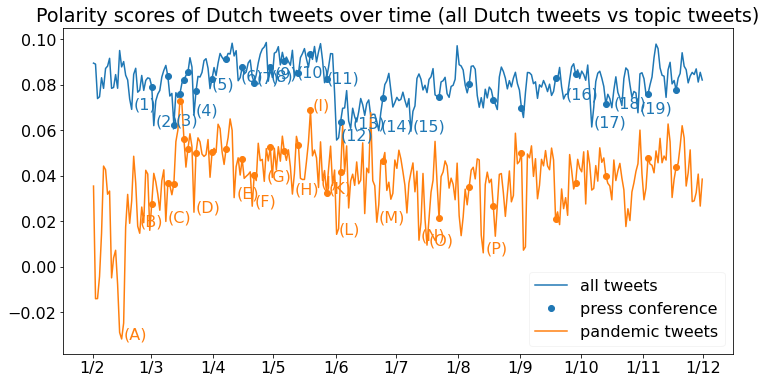

In [80]:
dummy = visualizeSentiment([{DATA:sentimentPerDay,LABEL:"all tweets",
                             HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference",ANNOTATE:annotate},
                            {DATA:sentimentPerDayTopic,LABEL:"pandemic tweets",HIGHLIGHT:highlight,ANNOTATE:annotateTopic}],
                           title=DEFAULTTITLE+" (all Dutch tweets vs topic tweets)")

A. 20200215 COVID-19 death on Dutch cruiseship
B. 20200223 Italy outbreak
C. 20200308 news item: COVID-19 spreading in Europe
D. 20200322 news item: lack of social distancing in nature areas
E. 20200411 news item: Netherlands sent facemasks to China
F. 20200420 anti-climate protest on Twitter
G. 20200426 nurse complains about corona measurements non-compliance
H. 20200510 warnings about staying alert
I. 20200519 relaxation of COVID-19 measures announced
J. 20200523 critique on national head of intensive care
K. 20200527 news item: politician rejects EU's COVID-19 measures
L. 20200601 lack of social distancing at Amsterdam BLM demonstration
M. 20200621 The Hague demonstration cancelled for social distancing
N. 20200712 news item: facemask related murder in France
O. 20200716 discussion about initial health care worker safety
P. 20200813 coalition leaves parliament to avoid vote on health care worker salaries

In [81]:
sortDatesBySentiment(sentimentPerDayTopic,month="202011")

[('20201129-12', {'sentiment': 0.026692518107127545, 'count': 25198}),
 ('20201125-12', {'sentiment': 0.0286659182880017, 'count': 22887}),
 ('20201126-12', {'sentiment': 0.02901360079951778, 'count': 25157}),
 ('20201101-12', {'sentiment': 0.029453395965303192, 'count': 26490}),
 ('20201115-12', {'sentiment': 0.030475299636978804, 'count': 20986}),
 ('20201127-12', {'sentiment': 0.0326331834556708, 'count': 27825}),
 ('20201102-12', {'sentiment': 0.0346272437039935, 'count': 37409}),
 ('20201122-12', {'sentiment': 0.03550671780316045, 'count': 21421}),
 ('20201116-12', {'sentiment': 0.038494539242830854, 'count': 26699}),
 ('20201130-12', {'sentiment': 0.03854535978326601, 'count': 32347}),
 ('20201128-12', {'sentiment': 0.04076619344099703, 'count': 27781}),
 ('20201123-12', {'sentiment': 0.041300625051809266, 'count': 23097}),
 ('20201106-12', {'sentiment': 0.04132780321439043, 'count': 23069}),
 ('20201117-12', {'sentiment': 0.04386027535437437, 'count': 32391}),
 ('20201105-12', {

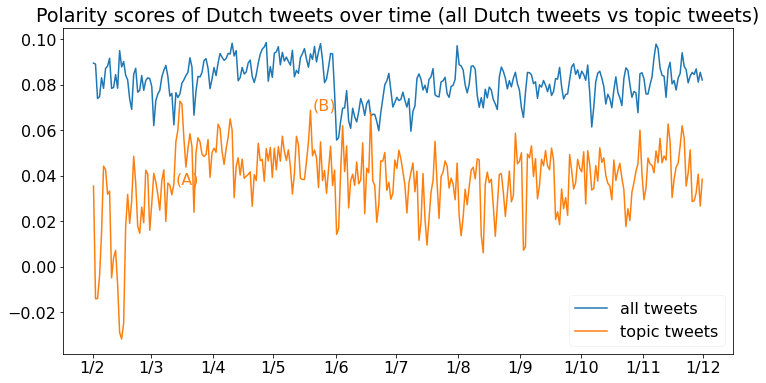

In [82]:
annotatePaper = [("20200312-12","20200313-12","(A)"),
                 ("20200519-12","20200520-12","(B)")]

dummy = visualizeSentiment([{DATA:sentimentPerDay,LABEL:"all tweets",
                             HIGHLIGHT:[],HIGHLIGHTLABEL:"",ANNOTATE:[]},
                            {DATA:sentimentPerDayTopic,LABEL:"topic tweets",HIGHLIGHT:[],
                             ANNOTATE:annotatePaper}],
                           title=DEFAULTTITLE+" (all Dutch tweets vs topic tweets)")

In [83]:
def show_dates_higher_covid_sentiment():
    print([(d,sentimentPerDay[d][SENTIMENT],sentimentPerDayTopic[d][SENTIMENT]) for d in sentimentPerDayTopic \
           if sentimentPerDayTopic[d][SENTIMENT] > sentimentPerDay[d][SENTIMENT]])

show_dates_higher_covid_sentiment()

[('20200618-12', 0.06630220089228812, 0.0677647417437394)]


In [84]:
[(hourString,sentimentPerDayTopic[hourString]) \
 for hourString in sorted(sentimentPerDayTopic.keys(),key=lambda h:sentimentPerDayTopic[h][SENTIMENT]) if re.search("202010",hourString)]

[('20201023-12', {'sentiment': 0.01769144820136654, 'count': 43491}),
 ('20201025-12', {'sentiment': 0.020334921937698605, 'count': 35692}),
 ('20201024-12', {'sentiment': 0.02551735214534725, 'count': 36560}),
 ('20201003-12', {'sentiment': 0.027618495700655755, 'count': 50335}),
 ('20201016-12', {'sentiment': 0.029461633070481857, 'count': 56159}),
 ('20201026-12', {'sentiment': 0.03291653245855591, 'count': 42937}),
 ('20201006-12', {'sentiment': 0.03373969013967533, 'count': 64421}),
 ('20201022-12', {'sentiment': 0.03380868651245651, 'count': 37591}),
 ('20201007-12', {'sentiment': 0.034462862074976286, 'count': 55668}),
 ('20201015-12', {'sentiment': 0.03552917528026844, 'count': 60536}),
 ('20201014-12', {'sentiment': 0.03673152236674155, 'count': 82383}),
 ('20201027-12', {'sentiment': 0.036914966345902536, 'count': 43049}),
 ('20201009-12', {'sentiment': 0.03766721721654512, 'count': 55274}),
 ('20201018-12', {'sentiment': 0.037917880256976795, 'count': 46355}),
 ('20201021-12

### Two per-topic graphs

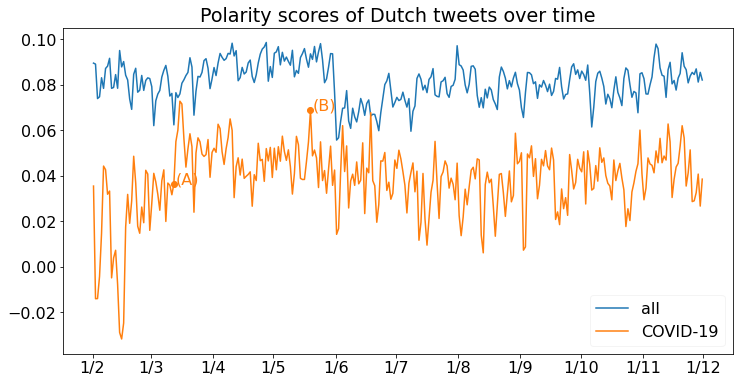

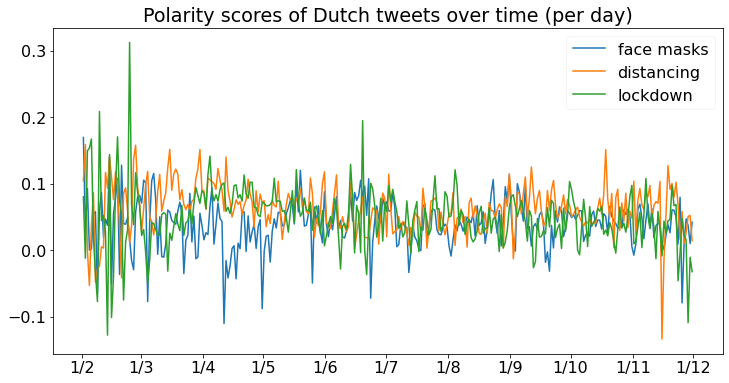

In [85]:
highlightPaper = ["20200312-12","20200519-12"]
annotatePaper = [("20200312-12","20200313-12","(A)"),
                 ("20200519-12","20200520-12","(B)")]

dummy = visualizeSentiment([
            {DATA:sentimentPerDay,LABEL:"all",HIGHLIGHT:[],HIGHLIGHTLABEL:"",ANNOTATE:[]},
            {DATA:sentimentPerDayTopic,LABEL:"COVID-19",HIGHLIGHT:highlightPaper,HIGHLIGHTLABEL:"",ANNOTATE:annotatePaper}],
            title=DEFAULTTITLE)
dummy = visualizeSentiment([
            {DATA:sentimentPerDayMondkapje,LABEL:"face masks",HIGHLIGHT:"",HIGHLIGHTLABEL:"",ANNOTATE:""},
            {DATA:sentimentPerDayDistance,LABEL:"distancing",HIGHLIGHT:"",HIGHLIGHTLABEL:"",ANNOTATE:""},
            {DATA:sentimentPerDayLockdown,LABEL:"lockdown",HIGHLIGHT:"",HIGHLIGHTLABEL:"",ANNOTATE:""}],
            title=DEFAULTTITLE+" (per day)")

In [86]:
def movingAverage(sentiment_per_day,size):
    sentiment_per_day_items = list(sentiment_per_day.items())
    new_sentiment_per_day_items = []
    for i in range(0,len(sentiment_per_day_items)):
        new_sentiment_per_day_items.append((sentiment_per_day_items[i][0],{SENTIMENT:0, COUNT:0}))
        for j in range(i-size+1+round(0.5*size),i+1+round(0.5*size)):
            if j >= 0 and j < len(sentiment_per_day):
                new_sentiment_per_day_items[-1][1][SENTIMENT] += sentiment_per_day_items[j][1][SENTIMENT]*sentiment_per_day_items[j][1][COUNT]
                new_sentiment_per_day_items[-1][1][COUNT] += sentiment_per_day_items[j][1][COUNT]
        new_sentiment_per_day_items[-1][1][SENTIMENT] /= new_sentiment_per_day_items[-1][1][COUNT]
    return(dict(new_sentiment_per_day_items))

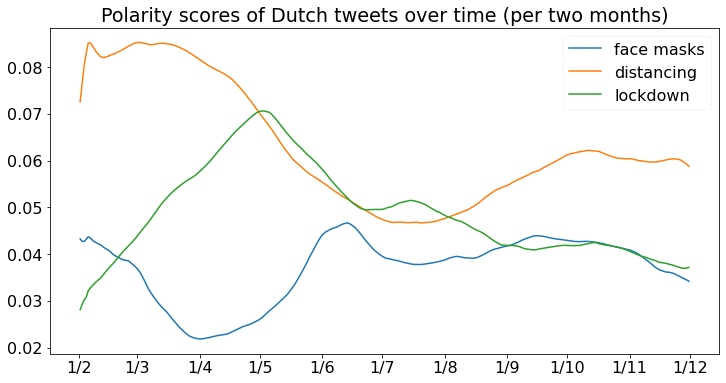

In [93]:
NBROFDAYS = 60
EXTRASMOOTHDAYS = 30

mondkapjeData = movingAverage(movingAverage(sentimentPerDayMondkapje,NBROFDAYS),EXTRASMOOTHDAYS)
distanceData = movingAverage(movingAverage(sentimentPerDayDistance,NBROFDAYS),EXTRASMOOTHDAYS)
lockdownData = movingAverage(movingAverage(sentimentPerDayLockdown,NBROFDAYS),EXTRASMOOTHDAYS)

dummy = visualizeSentiment([
            {DATA:mondkapjeData,LABEL:"face masks",HIGHLIGHT:"",HIGHLIGHTLABEL:"",ANNOTATE:""},
            {DATA:distanceData,LABEL:"distancing",HIGHLIGHT:"",HIGHLIGHTLABEL:"",ANNOTATE:""},
            {DATA:lockdownData,LABEL:"lockdown",HIGHLIGHT:"",HIGHLIGHTLABEL:"",ANNOTATE:""}],
            title=DEFAULTTITLE+" (per two months)",skip_factor=0)

### Two plots in one figure

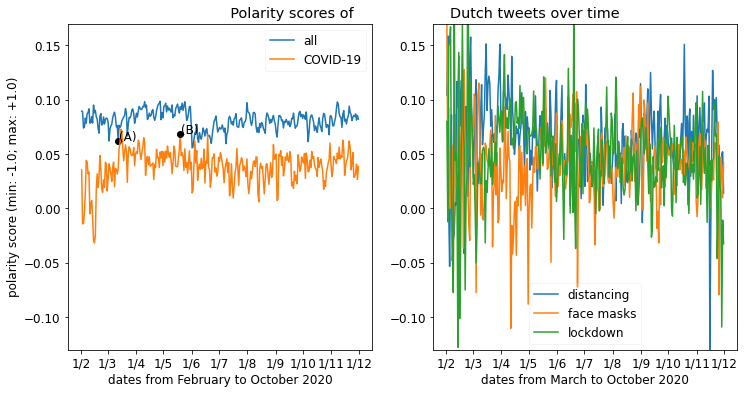

In [96]:
PLOTFILENAME = "sentiment-all-split.png"
highlightPaperAll = ["20200312-12"]
annotatePaperAll = [("20200312-12","20200313-12","(A)")]
highlightPaperCovid = ["20200519-12"]
annotatePaperCovid = [("20200519-12","20200520-12","(B)")]

dateFormat = DATEFORMATMONTH
dataSources = [{DATA:sentimentPerDay,LABEL:"all",HIGHLIGHT:highlightPaperAll,HIGHLIGHTLABEL:"",ANNOTATE:annotatePaperAll},
               {DATA:sentimentPerDayTopic,LABEL:"COVID-19",HIGHLIGHT:highlightPaperCovid,HIGHLIGHTLABEL:"",ANNOTATE:annotatePaperCovid}]
title = DEFAULTTITLE
YMIN = -0.13
YMAX =0.17

if True:
    font = {"size":12}
    matplotlib.rc("font",**font)
    fig,ax = plt.subplots(figsize=(12,6))
    ax = plt.subplot(121)
    plt.ylim(YMIN,YMAX) # was -0.14,0.18
    ax.xaxis.set_major_formatter(mdates.DateFormatter(dateFormat))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        lineData = ax.plot_date([stringToDate(key) for key in data if data[key][COUNT] > 1],\
                     [data[key][SENTIMENT] for key in data if data[key][COUNT] > 1],xdate=True,fmt="-",label=label)
        if HIGHLIGHT in dataSources[i]:
            highlight = dataSources[i][HIGHLIGHT]
            color = lineData[-1].get_color()
            if not HIGHLIGHTLABEL in dataSources[i]:
                ax.plot_date([stringToDate(key) for key in highlight],
                             [data[key][SENTIMENT] for key in highlight],\
                             fmt="o",color="black")
            else:
                highlightlabel = dataSources[i][HIGHLIGHTLABEL]
                ax.plot_date([stringToDate(key) for key in highlight],
                             [data[key][SENTIMENT] for key in highlight],\
                             fmt="o",color="black",label=highlightlabel)
        if ANNOTATE in dataSources[i]:
            for date1,date2,text in dataSources[i][ANNOTATE]:
                plt.annotate(text,(stringToDate(date2),data[date1][SENTIMENT]),color="black")
    plt.title("                               Polarity scores of")
    plt.xlabel("dates from February to October 2020")
    plt.ylabel("polarity score (min: -1.0; max: +1.0)")
    plt.legend(framealpha=0.2)

dataSources = [{DATA:sentimentPerDayDistance,LABEL:"distancing",HIGHLIGHT:highlightPaper,HIGHLIGHTLABEL:"",ANNOTATE:annotatePaper},
              {DATA:sentimentPerDayMondkapje,LABEL:"face masks",HIGHLIGHT:highlightPaper,HIGHLIGHTLABEL:"",ANNOTATE:annotatePaper},
              {DATA:sentimentPerDayLockdown,LABEL:"lockdown",HIGHLIGHT:highlightPaper,HIGHLIGHTLABEL:"",ANNOTATE:annotatePaper}]

if True:
    ax = plt.subplot(122)
    plt.ylim(YMIN,YMAX)
    ax.xaxis.set_major_formatter(mdates.DateFormatter(dateFormat))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        x = [key for key in data if data[key][COUNT] > 1]
        y = [data[key][SENTIMENT] for key in data if data[key][COUNT] > 1]
        lineData = ax.plot_date([stringToDate(key) for key in x],y,xdate=True,fmt="-",label=label)
        plottedData = {x[i]:y[i] for i in range(0,len(x))}
        #if HIGHLIGHT in dataSources[i]:
        #    highlight = dataSources[i][HIGHLIGHT]
        #    color = lineData[-1].get_color()
        #    if not HIGHLIGHTLABEL in dataSources[i]:
        #        ax.plot_date([stringToDate(key) for key in highlight],
        #                     [plottedData[key] for key in highlight],\
        #                     fmt="o",color=color)
        #    else:
        #        highlightlabel = dataSources[i][HIGHLIGHTLABEL]
        #        ax.plot_date([stringToDate(key) for key in highlight],
        #                     [plottedData[key] for key in highlight],\
        #                     fmt="o",color=color,label=highlightlabel)
        #if ANNOTATE in dataSources[i]:
        #    for date1,date2,text in dataSources[i][ANNOTATE]:
        #        plt.annotate(text,(stringToDate(date2),plottedData[date1]),color=color)
    plt.title("Dutch tweets over time                      ")
    plt.legend(framealpha=0.2)
    plt.xlabel("dates from March to October 2020")
    plt.savefig(PLOTFILENAME)
    plt.show()

In [97]:
def averageSentiment(sentimentPerDay):
    sentiment = 0.0
    count = 0
    for date in sentimentPerDay.keys():
        sentiment += sentimentPerDay[date][SENTIMENT]*sentimentPerDay[date][COUNT]
        count += sentimentPerDay[date][COUNT]
    return(sentiment/count)

print(averageSentiment(sentimentPerDayMondkapje),averageSentiment(sentimentPerDayDistance),averageSentiment(sentimentPerDayLockdown))

0.0366124326036991 0.06342924497650008 0.05111258090365614


Average sentiment scores:
1. Twitter: face masks: 0.037; distancing: 0,064; lockdown: 0.054 (-1 Nov)
2. Nu.nl: face masks: 0.055; distancing: 0.056 (-1 Aug)
3. Reddit: face masks: 0.050; distancing: 0.068 (-1 Aug)

## STOP HERE

## Show positive tweets

In [43]:
def showTweetTextWithSentiment(dataDir,query,filePattern=DEFAULTFILEPATTERN):
    fileList = sorted(os.listdir(dataDir))
    tweetSentPairs = []
    for inFileName in fileList:
        if re.search(filePattern,inFileName):
            squeal(inFileName)
            if os.path.exists(dataDir+inFileName):
                dfSent = pd.read_csv(dataDir+inFileName,header=None,index_col=0)
                dfText = pd.read_csv(DATADIRECTORYTEXT+inFileName,index_col=IDSTR)
                selectedDict = {idStr:dfText.loc[idStr][TEXT] for idStr in dfText.index if re.search(query,dfText.loc[idStr][TEXT],flags=re.IGNORECASE)}
                for idStr in selectedDict.keys():
                    try:
                        tweetSentPairs.append((dfSent.loc[idStr][1],selectedDict[idStr]))
                    except: pass
    tweetSentPairs = sorted(tweetSentPairs,key=lambda e:e[0],reverse=True)
    return(tweetSentPairs)

tweetSentPairs = showTweetTextWithSentiment(DATADIRECTORYSENTTOPIC,query="coronapocalypse",filePattern="20200316")

20200316-07.out.gz


KeyboardInterrupt: 

In [ ]:
tweetSentPairs[0:10]

In [ ]:
sum([tweetSentPairs[i][0] for i in range(0,len(tweetSentPairs))])/len(tweetSentPairs)

## Visualize sentiment of single press conference day

In [33]:
def convertDate(dateString1,dateString2,dateString3):
    return(re.sub(dateString1,dateString2,dateString3))

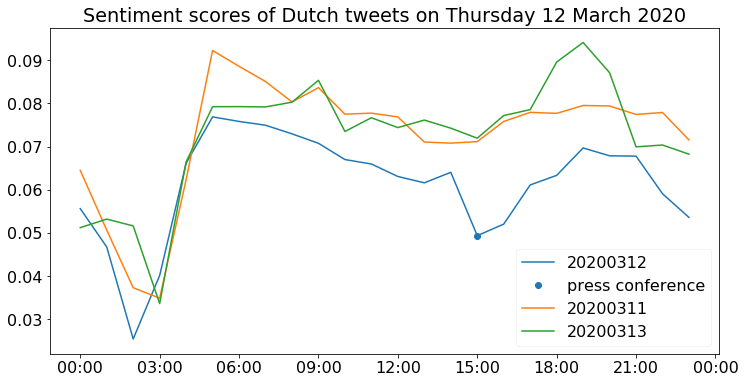

In [34]:
dummy = visualizeSentiment([{DATA:{k:sentimentPerHour[k] for k in sentimentPerHour.keys() \
                                   if re.search(r"^20200312",k)},\
                             LABEL:"20200312",HIGHLIGHT:["20200312-15"],HIGHLIGHTLABEL:"press conference"},\
                            {DATA:{convertDate("20200311","20200312",k):sentimentPerHour[k] for k in sentimentPerHour.keys() 
                                   if re.search(r"^20200311",k)},LABEL:"20200311"},\
                            {DATA:{convertDate("20200313","20200312",k):sentimentPerHour[k] for k in sentimentPerHour.keys() 
                                   if re.search(r"^20200313",k)},LABEL:"20200313"}],\
                           title="Sentiment scores of Dutch tweets on Thursday 12 March 2020",dateFormat=DATEFORMATHRSMINS)

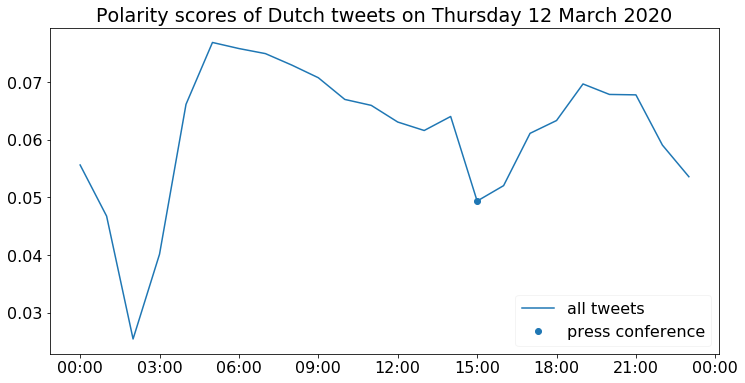

In [38]:
dummy = visualizeSentiment([{DATA:{k:sentimentPerHour[k] for k in sentimentPerHour.keys() \
                                   if re.search(r"^20200312",k)},\
                             LABEL:"all tweets",HIGHLIGHT:["20200312-15"],HIGHLIGHTLABEL:"press conference"}],\
                           title="Polarity scores of Dutch tweets on Thursday 12 March 2020",dateFormat=DATEFORMATHRSMINS)

In [35]:
{DATA:{k:sentimentPerHour[k] for k in sentimentPerHour.keys() if re.search(r"^20200311",k)},LABEL:""}

{'data': {'20200311-00': {'sentiment': 0.06446679783330554, 'count': 13549},
  '20200311-01': {'sentiment': 0.05065099050536058, 'count': 7093},
  '20200311-02': {'sentiment': 0.03729425525332573, 'count': 3335},
  '20200311-03': {'sentiment': 0.03487267984552804, 'count': 2360},
  '20200311-04': {'sentiment': 0.06233807276832318, 'count': 2290},
  '20200311-05': {'sentiment': 0.09223120958443641, 'count': 3311},
  '20200311-06': {'sentiment': 0.08857570140883275, 'count': 8833},
  '20200311-07': {'sentiment': 0.08504366265683548, 'count': 19967},
  '20200311-08': {'sentiment': 0.08031664579849708, 'count': 28727},
  '20200311-09': {'sentiment': 0.08363725686849516, 'count': 31696},
  '20200311-10': {'sentiment': 0.07748921817232901, 'count': 33007},
  '20200311-11': {'sentiment': 0.07772837999609072, 'count': 34125},
  '20200311-12': {'sentiment': 0.07684535988365354, 'count': 33708},
  '20200311-13': {'sentiment': 0.07103485245328345, 'count': 32615},
  '20200311-14': {'sentiment': 0

## Compare day graph with previous years

In [ ]:
DATADIRECTORYALL2019 = "../data/sentiment/2019/"
TEMPERATURESFILE = "../data/temperatures.csv" 

def changeYearTo2020(dataIn):
    dataOut = {}
    for dateString in dataIn:
        dateString2020 = re.sub(r"20[0-9][0-9]","2020",dateString)
        dataOut[dateString2020] = dataIn[dateString]
    return(dataOut)

sentimentPerHour2019 = getSentimentPerHour(DATADIRECTORYALL2019)
sentimentPerDay2019 = makeSentimentPerDay(sentimentPerHour2019)
ax = visualizeSentiment([{DATA:sentimentPerDay,LABEL:"2020 per day",\
                          HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"},\
                         {DATA:changeYearTo2020(sentimentPerDay2019),LABEL:"2019 per day",\
                          HIGHLIGHT:["20200315-12","20200318-12"],HIGHLIGHTLABEL:"terror attack"}],
                         title=DEFAULTTITLE)

## Add daily temperatures to plot

In [ ]:
def readTemperatures():
    temperatures = pd.read_csv(TEMPERATURESFILE,header=None)
    temperatures = { (str(temperatures[0][i])+"-12"):(temperatures[1][i]/10) for i in range(0,len(temperatures))}
    return(temperatures)

temperatures = readTemperatures()

ax2 = ax.twinx()
ax2.set_ylim([-20,40])
dummy = ax2.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in temperatures],\
                      [temperatures[key] for key in temperatures],xdate=True,\
                      fmt="--",color="990000",label="temperature")

## Check relation temperature - sentiment

In [ ]:
plt.figure(figsize=(3,3))
plt.gcf().subplots_adjust(left=0.2)
x = [sentimentPerDay[key][SENTIMENT] for key in temperatures]
y = [temperatures[key] for key in temperatures]
plt.scatter(x,y)
plt.show()

In [ ]:
np.corrcoef(x,y)[0][1]

## Check relation sentiment today - yesterday 

In [ ]:
plt.figure(figsize=(3,3))
plt.gcf().subplots_adjust(left=0.2)
x = [sentimentPerDay[key][SENTIMENT] for key in sentimentPerDay]
y = [sentimentPerDay[key][SENTIMENT] for key in sentimentPerDay]
x.pop(-1)
y.pop(0)
plt.scatter(x,y)
plt.show()

In [ ]:
np.corrcoef(x,y)[0][1]

## Sort days by sentiment score

Dates of Dutch government press conferences related to corona crisis:

1. Sunday 1 March 2020: https://www.youtube.com/watch?v=rg9aM97Pu38
2. Monday 9 March 2020: https://www.youtube.com/watch?v=xz-DtYHGdLA
3. Thursday 12 March 2020: https://www.youtube.com/watch?v=0iD1FN6I87Y (start: around 15:15 PM)
4. Sunday 15 March 2020: https://www.youtube.com/watch?v=j94ULn90xg8
5. Tuesday 17 March 2020: https://www.youtube.com/watch?v=KuXj3c1F8WY
6. Thursday 19 March 2020: https://www.youtube.com/watch?v=Yqx0PlSnUFE
7. Monday 23 March 2020: https://www.youtube.com/watch?v=mcpLFX_L9o8
8. Tuesday 31 March 2020: https://www.youtube.com/watch?v=FNuzw3wplow
9. Tuesday 7 April 2020: https://www.youtube.com/watch?v=-j3_mmZcBZU
10. Wednesday 15 April 2020: https://www.youtube.com/watch?v=n1-rSb3j0UM
11. Tuesday 21 April 2020: https://www.youtube.com/watch?v=Yjx7SPtq7Bk
12. Wednesday 29 April 2020: https://www.youtube.com/watch?v=dfhzIGagbOw
13. Wednesday 6 May 2020: https://www.youtube.com/watch?v=rBtDphRcPKA
14. Wednesday 13 May 2020: https://www.youtube.com/watch?v=zISG9KkuAQ0
15. Tuesday 19 May 2020: https://www.youtube.com/watch?v=MlAk_RMTHZU
16. Wednesday 27 May 2020: https://www.youtube.com/watch?v=M0qBpBz_5h8
17. Wednesday 3 June 2020: https://www.youtube.com/watch?v=rsIUKfLjf8k

In [ ]:
{k:round(v[SENTIMENT],4) for k,v in sorted(sentimentPerDay.items(),key=lambda item:item[1][SENTIMENT])}

## Process data from RIVM query

In [ ]:
sentimentPerHour = getSentimentPerHour(DATADIRECTORYRIVM)
sentimentPerDay = makeSentimentPerDay(sentimentPerHour)
visualizeSentiment([{DATA:sentimentPerHour,LABEL:"per hour"},{DATA:sentimentPerDay,LABEL:"per day"}],\
                   title=DEFAULTTITLE+" (RIVM query)")

## Sort days by sentiment score

In [ ]:
{k:v for k,v in sorted(sentimentPerDay.items(),key=lambda item:item[1][SENTIMENT])}

## Examine tweet texts from day with extreme sentiment

In [45]:
import gzip
import json
import numpy as np
from library import getTweetText

def removeNewlines(text):
    return(re.sub(r"\n",r" ",text))

HOURSPERDAY = 24
DATE = "20200901"
TWEETDIRECTORYRIVM = "../data/rivm/"

tweetTexts = []
for hour in range(0,HOURSPERDAY):
    hour = str(hour).zfill(2)
    inFile = gzip.open(TWEETDIRECTORYRIVM+DATE+"-"+hour+".rivm.gz")
    for line in inFile:
        jsonData = json.loads(line)
        tweetText = removeNewlines(getTweetText(jsonData))
        tweetTexts.append(tweetText)
    inFile.close()
    
pd.DataFrame(tweetTexts)[0].value_counts()[0:20]

FileNotFoundError: [Errno 2] No such file or directory: '../data/rivm/20200901-00.rivm.gz'

## Process sentiment of topic

In [ ]:
def readSentiment(fileName):
    return(pd.read_csv(fileName,index_col="date").T.to_dict())

In [ ]:
DATADIR = "../data/sentiment/"
TOPIC = "corona|covid|flattenthecurve|blijfthuis|rivm|mondkapje|huisarts|houvol"
EXTENSION = ".csv"

# sentimentPerHourTopic = readSentiment(DATADIR+TOPIC+EXTENSION)
sentimentPerHourTopic = getSentiment()

In [ ]:
sentimentPerDayTopic = makeSentimentPerDay(sentimentPerHourTopic)
dummy = visualizeSentiment([{DATA:sentimentPerDay,LABEL:"all",
                            HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"},
                            {DATA:sentimentPerDayTopic,LABEL:"topic",\
                             HIGHLIGHT:highlight,HIGHLIGHTLABEL:"press conference"}],\
                           title=DEFAULTTITLE+" (all Dutch tweets vs topic tweets)")

In [ ]:
for selectedDates in "202002 202003 202004 202005[01]".split():
    nbrOfTweetsAll = sum([sentimentPerDay[date][COUNT] for date in sentimentPerDay if re.search(selectedDates,date)])
    nbrOfTweetsTopic = sum([sentimentPerDayTopic[date][COUNT] for date in sentimentPerDayTopic if re.search(selectedDates,date)])
    print(selectedDates,round(nbrOfTweetsTopic/nbrOfTweetsAll,3))

In [ ]:
sentimentPerDay